In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
from math import sqrt

In [2]:
%matplotlib inline

matplotlib.rcParams.update({
    'backend': 'ps',
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'text.usetex': True,
})


def latexify(fig_width=None, fig_height=None, columns=1, height_scale=1.):
    """Return matplotlib's RC params for LaTeX plotting.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width * golden_mean * height_scale # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    new_params = {
        'axes.labelsize': 8, # fontsize for x and y labels (was 10)
        'axes.titlesize': 8,
        'legend.fontsize': 8, # was 10
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'figure.figsize': [fig_width,fig_height],
        'font.family': ['serif'],
    }
    return matplotlib.rc_context(rc=new_params)

In [3]:
df = pd.DataFrame(np.random.randn(10,2))
df.columns = ['Column 1', 'Column 2']

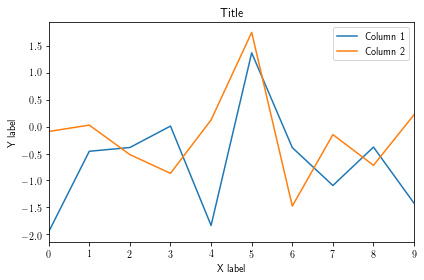

In [4]:
ax = df.plot()
ax.set_xlabel("X label")
ax.set_ylabel("Y label")
ax.set_title("Title")
plt.tight_layout()
plt.savefig("images/image1.pdf")

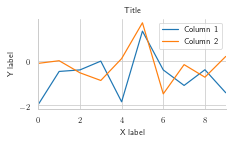

In [5]:
with sns.plotting_context('paper'), sns.axes_style('whitegrid'), latexify(columns=1):
    ax = df.plot()
    ax.set_xlabel("X label")
    ax.set_ylabel("Y label")
    ax.set_title("Title")
    sns.despine()
    plt.tight_layout()
    plt.savefig("images/image2.pdf")

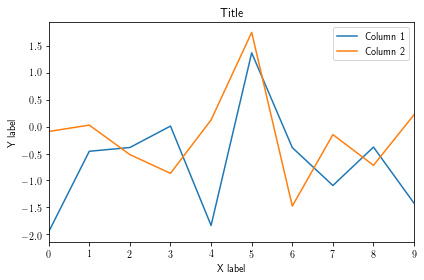

In [6]:
ax = df.plot()
ax.set_xlabel("X label")
ax.set_ylabel("Y label")
ax.set_title("Title")
plt.tight_layout()
plt.show()

In [7]:
import itertools
import json
import os
from itertools import chain
from functools import reduce


class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


def unique(l):
    return list(set(l))


def load_progress(progress_path, verbose=True):
    if verbose:
        print("Reading %s" % progress_path)

    if progress_path.endswith('.csv'):
        return pd.read_csv(progress_path, index_col=None, comment='#')

    ds = []
    with open(progress_path, 'rt') as fh:
        for line in fh:
            ds.append(json.loads(line))
    return pd.DataFrame(ds)


def flatten_dict(d):
    flat_params = dict()
    for k, v in d.items():
        if isinstance(v, dict):
            v = flatten_dict(v)
            for subk, subv in flatten_dict(v).items():
                flat_params[k + "." + subk] = subv
        else:
            flat_params[k] = v
    return flat_params


def load_params(params_json_path):
    with open(params_json_path, 'r') as f:
        data = json.load(f)
        if "args_data" in data:
            del data["args_data"]
        if "exp_name" not in data:
            data["exp_name"] = params_json_path.split("/")[-3]
    return data


def first_that(criterion, l):
    return next(x for x in l if criterion(x))


def load_exps_data(
    exp_folder_paths, 
    ignore_missing_keys=False, 
    verbose=False,
    isprogress=lambda x: x.startswith('progress'),
    isconfig=lambda x: x.startswith('variant')
):
    if isinstance(exp_folder_paths, str):
        exp_folder_paths = [exp_folder_paths]
    exps = list(
        filter( # entries that have progress files
            lambda x: any(isprogress(y) for y in x[1]),
            filter( # entries that have >0 files
                lambda x: x[1],
                map( # only (path, files)
                    lambda x: (x[0], x[2]),
                    reduce( # (path, subpath, files) for all dirs
                        chain, 
                        map( # (path, subpath, files) for each dir
                            os.walk, 
                            exp_folder_paths))))))
    if verbose:
        print("finished walking exp folders")
    exps_data = []
    for exp_path, files in exps:
        try:
            progress_path = os.path.join(exp_path, first_that(isprogress, files))
            progress = load_progress(progress_path, verbose=verbose)
            if any(isconfig(file) for file in files):
                params = load_params(
                    os.path.join(exp_path, first_that(isconfig, files)))
            else:
                params = dict(exp_name="experiment")
            exps_data.append(AttrDict(
                progress=progress,
                params=params,
                flat_params=flatten_dict(params)
            ))
        except (IOError, pd.errors.EmptyDataError) as e:
            if verbose:
                print(e)

    # a dictionary of all keys and types of values
    all_keys = dict()
    for data in exps_data:
        for key in data.flat_params.keys():
            if key not in all_keys:
                all_keys[key] = type(data.flat_params[key])

    # if any data does not have some key, specify the value of it
    if not ignore_missing_keys:
        default_values = dict()
        for data in exps_data:
            for key in sorted(all_keys.keys()):
                if key not in data.flat_params:
                    if key not in default_values:
                        default = None
                        default_values[key] = default
                    data.flat_params[key] = default_values[key]

    return exps_data

def smart_repr(x):
    if isinstance(x, tuple):
        if len(x) == 0:
            return "tuple()"
        elif len(x) == 1:
            return "(%s,)" % smart_repr(x[0])
        else:
            return "(" + ",".join(map(smart_repr, x)) + ")"
    else:
        if hasattr(x, "__call__"):
            return "__import__('pydoc').locate('%s')" % \
                (x.__module__ + "." + x.__name__)
        else:
            return repr(x)

def extract_distinct_params(exps_data,
                            excluded_params=('seed', 'log_dir'),
                            l=1):
    try:
        repr_config_pairs = [
            smart_repr(kv) for d in exps_data for kv in d.flat_params.items()]
        uniq_pairs = unique(repr_config_pairs)
        evald_pairs = map(eval, uniq_pairs)
        stringified_pairs = sorted(
            evald_pairs, 
            key=lambda x: tuple("" if it is None else str(it) for it in x))
    except Exception as e:
        print(e)
        import ipdb
        ipdb.set_trace()

    proposals = [
        (k, [x[1] for x in v])
        for k, v in itertools.groupby(stringified_pairs, lambda x: x[0])]

    filtered = [(k, v) for (k, v) in proposals if len(v) > l and all(
        [k.find(excluded_param) != 0 for excluded_param in excluded_params])]
    return filtered


class Selector(object):
    def __init__(self, exps_data, filters=None):
        self._exps_data = exps_data
        self._filters = tuple() if filters is None else tuple(filters)

    def where(self, k, v):
        includes = lambda exp: str(exp.flat_params.get(k, None)) == str(v)
        return Selector(self._exps_data, self._filters + (includes,))

    def where_not(self, k, v):
        excludes = lambda exp: str(exp.flat_params.get(k, None)) != str(v)
        return Selector(self._exps_data, self._filters + (excludes,))

    def _check_exp(self, exp):
        return all(condition(exp) for condition in self._filters)

    def extract(self):
        return list(filter(self._check_exp, self._exps_data))

In [8]:
exps_data = load_exps_data('../../data/bracis/classic_control/comparison-v7')

alg_name = {
    'vanilla': "VPG",
    'natural': "NPG",
    'trpo': "TRPO"}
for exp_data in exps_data:
    params = exp_data.flat_params
    params['alg'] = alg_name.get(params['alg'], params['alg'])
    
exps_data[0].progress.tail()

,AverageEpisodeLength,AveragePolicyProb[0],AveragePolicyProb[1],AverageReturn,Entropy,ExplainedVariance,Iteration,MaxEpisodeLength,MaxReturn,MeanKL,MinEpisodeLength,MinReturn,Perplexity,StdEpisodeLength,StdReturn,TotalNEpisodes,TotalNSamples,ValueLoss
245,166.52,0.476084,0.523916,166.52,0.098271,0.032499,246,500,500.0,0.000741,10,10.0,1.125993,132.100453,132.100453,4801,492000,771.276062
246,159.01,0.519212,0.480788,159.01,0.107237,0.210010,247,500,500.0,0.000889,10,10.0,1.137051,126.270067,126.270067,4818,494000,624.839294
247,159.26,0.471413,0.528587,159.26,0.108492,0.168115,248,500,500.0,0.000766,10,10.0,1.140009,124.341274,124.341274,4832,496000,609.101196
248,163.75,0.485455,0.514545,163.75,0.105595,0.181981,249,500,500.0,0.000643,10,10.0,1.135205,124.192784,124.192784,4844,498000,594.049438
249,149.96,0.488308,0.511692,149.96,0.109236,0.135213,250,500,500.0,0.000805,12,12.0,1.140499,112.755747,112.755747,4861,500000,711.167114


In [9]:
from collections import OrderedDict

def lineplot_instructions(
    exps_data,
    x,
    y,
    split_key=None,
    hue=None,
    size=None,
    style=None,
    estimator='mean',
    include=dict(),
    exclude=dict(),
):
    plot_kwargs = dict(
        x=x,
        y=y,
        hue=hue,
        size=size,
        style=style,
        estimator=estimator,
        ci='sd')
    if estimator is None:
        plot_kwargs['units'] = 'unit'

    selector = Selector(exps_data)
    for k, v in include.items():
        selector = selector.where(k, str(v))
    for k, v in exclude.items():
        selector = selector.where_not(k, str(v))

    if split_key is not None:
        vs = dict(sorted(extract_distinct_params(exps_data))).get(split_key, [])
        split_selectors = [selector.where(split_key, v) for v in vs]
        split_titles = list(map(str, vs))
    else:
        split_selectors = [selector]
        split_titles = ["Experiment"]

    plots = []
    keys = tuple(filter(None, (hue, size, style))) + ('unit',)
    for split_selector, split_title in zip(split_selectors, split_titles):
        split_exps_data = split_selector.extract()
        if len(split_exps_data) < 1:
            continue

        distinct_params = OrderedDict(
            sorted(extract_distinct_params(split_exps_data)))
        key_orders = dict(
            hue_order=distinct_params.get(hue, None),
            size_order=distinct_params.get(size, None),
            style_order=distinct_params.get(style, None))
        lineplot_kwargs = AttrDict({**plot_kwargs, **key_orders})

        dataframes = []
        configs_and_data = (
            (exp.flat_params, exp.progress) for exp in split_exps_data)
        for enum, (config, dataframe) in enumerate(configs_and_data):
            config['unit'] = enum
            for key in filter(lambda key: key not in dataframe, keys):
                dataframe.insert(len(dataframe.columns), str(key), config[key])
            dataframes.append(dataframe)
        lineplot_kwargs.data = pd.concat(
            dataframes, ignore_index=True, sort=False)
        
        plots.append(AttrDict(
            title=split_title, lineplot_kwargs=lineplot_kwargs))
    return plots

In [10]:
plot_instructions = lineplot_instructions(
    exps_data,
    'TotalNSamples',
    'AverageReturn',
    split_key='env',
    hue='alg',
    estimator='mean',
)

noise_level = {
    'CartPole-v1': 0,
    'WeakGaussCartPole-v1': 1,
    'StndGaussCartPole-v1': 2,
    'StrgGaussCartPole-v1': 3,
}

final_title = {
    'CartPole-v1': "$\epsilon = 0$",
    'WeakGaussCartPole-v1': "$\epsilon\sim\mathcal{N}(0, 0.5)$",
    'StndGaussCartPole-v1': "$\epsilon\sim\mathcal{N}(0, 1.0)$",
    'StrgGaussCartPole-v1': "$\epsilon\sim\mathcal{N}(0, 1.5)$",
}

plot_instructions = sorted(plot_instructions, key=lambda inst: noise_level[inst.title])

plot_instructions[0].lineplot_kwargs.data.tail()

,ActualImprovement,AverageEpisodeLength,AveragePolicyProb[0],AveragePolicyProb[1],AverageReturn,Entropy,ExpectedImprovement,ExplainedVariance,ImprovementRatio,Iteration,...,MinReturn,Perplexity,StdEpisodeLength,StdReturn,TotalNEpisodes,TotalNSamples,ValueLoss,alg,unit,Objective
7495,NaN,500.0,0.492372,0.507628,500.0,0.523602,NaN,0.999951,NaN,246,...,500.0,1.709831,0.0,0.0,2348,492000,0.031442,VPG,29,0.019341
7496,NaN,500.0,0.512210,0.487790,500.0,0.521287,NaN,0.999931,NaN,247,...,500.0,1.705425,0.0,0.0,2352,494000,0.043382,VPG,29,0.032015
7497,NaN,500.0,0.501305,0.498695,500.0,0.533365,NaN,0.999949,NaN,248,...,500.0,1.724392,0.0,0.0,2356,496000,0.030457,VPG,29,0.022906
7498,NaN,500.0,0.500938,0.499062,500.0,0.532445,NaN,0.999943,NaN,249,...,500.0,1.723167,0.0,0.0,2360,498000,0.034089,VPG,29,0.010553
7499,NaN,500.0,0.497695,0.502305,500.0,0.534652,NaN,0.999948,NaN,250,...,500.0,1.726683,0.0,0.0,2364,500000,0.031057,VPG,29,0.029368


In [11]:
help(plt.subplots_adjust)

Help on function subplots_adjust in module matplotlib.pyplot:

subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    Tune the subplot layout.
    
    The parameter meanings (and suggested defaults) are::
    
      left  = 0.125  # the left side of the subplots of the figure
      right = 0.9    # the right side of the subplots of the figure
      bottom = 0.1   # the bottom of the subplots of the figure
      top = 0.9      # the top of the subplots of the figure
      wspace = 0.2   # the amount of width reserved for space between subplots,
                     # expressed as a fraction of the average axis width
      hspace = 0.2   # the amount of height reserved for space between subplots,
                     # expressed as a fraction of the average axis height
    
    The actual defaults are controlled by the rc file



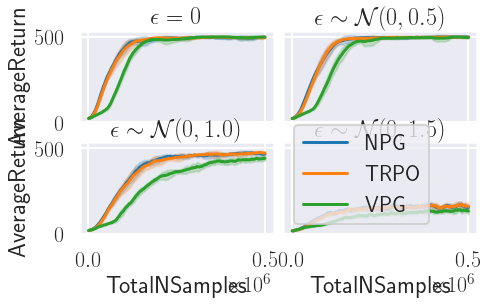

In [17]:
last = plot_instructions[-1]
with sns.plotting_context('paper'), sns.axes_style('darkgrid'), latexify(columns=2, height_scale=1/2):
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
    axes = axes.flatten()
    for plot_inst, ax in zip(plot_instructions, axes):
        lineplot_kwargs = plot_inst.lineplot_kwargs
        sns.lineplot(
            ax=ax, legend="full" if plot_inst is last else False, **lineplot_kwargs
        )
        ax.set_title(final_title[plot_inst.title])
        if lineplot_kwargs["data"][lineplot_kwargs["x"]].max() > 5e3:
            # Just some formatting niceness:
            # x-axis scale in scientific notation if max x is large
            plt.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))

    last_ax = axes[-1]
    handles, labels = last_ax.get_legend_handles_labels()
    last_ax.legend(handles=handles[1:], labels=labels[1:])

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05, hspace=0.2, left=0.07, right=0.99, top=0.9, bottom=0.19)
    plt.show()
#     plt.savefig("images/new_comp.pdf")

# leg = last_ax.get_legend()
# print([attr for attr in dir(leg) if "get" in attr])
# print("="*80)
# print([attr for attr in dir(leg) if "set" in attr])
# print(leg.get_visible())

In [13]:
plot_inst, = plot_instructions
with sns.plotting_context('paper'), sns.axes_style('darkgrid'), latexify(columns=2):
    sns.lineplot(legend="full", **plot_inst.lineplot_kwargs)
    sns.despine()
    plt.title("All Envs")
    plt.tight_layout()
    plt.savefig('images/all_envs.pdf')

RuntimeError: latex was not able to process the following string:
b'val_fn.class'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/Users/angelolovatto/.matplotlib/tex.cache/62a3eab760bf2e4d92940d16c9dd0d1c.te
x
LaTeX2e <2017-04-15>
Babel <3.10> and hyphenation patterns for 84 language(s) loaded.
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2017/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/inputenc.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/utf8.def
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/omsenc.dfu)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/local/texlive/2017/texmf-dist/tex/latex/was/gensymb.sty)
(/usr/local/texlive/2017/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./62a3eab760bf2e4d92940d16c9dd0d1c.aux)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 \fontsize{8.000000}{10.000000}{\rmfamily val_
                                                  fn.class}
No pages of output.
Transcript written on 62a3eab760bf2e4d92940d16c9dd0d1c.log.




Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x120e87620> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'val_fn.class'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/Users/angelolovatto/.matplotlib/tex.cache/2ac134a8019e6d605f626db6b2bc044d.te
x
LaTeX2e <2017-04-15>
Babel <3.10> and hyphenation patterns for 84 language(s) loaded.
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2017/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/inputenc.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/utf8.def
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/omsenc.dfu)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/local/texlive/2017/texmf-dist/tex/latex/was/gensymb.sty)
(/usr/local/texlive/2017/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file 2ac134a8019e6d605f626db6b2bc044d.aux.
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 \fontsize{8.000000}{10.000000}{\sffamily val_
                                                  fn.class}
No pages of output.
Transcript written on 2ac134a8019e6d605f626db6b2bc044d.log.




RuntimeError: latex was not able to process the following string:
b'val_fn.class'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/Users/angelolovatto/.matplotlib/tex.cache/2ac134a8019e6d605f626db6b2bc044d.te
x
LaTeX2e <2017-04-15>
Babel <3.10> and hyphenation patterns for 84 language(s) loaded.
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2017/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/inputenc.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/utf8.def
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/omsenc.dfu)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/local/texlive/2017/texmf-dist/tex/latex/was/gensymb.sty)
(/usr/local/texlive/2017/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./2ac134a8019e6d605f626db6b2bc044d.aux)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 \fontsize{8.000000}{10.000000}{\sffamily val_
                                                  fn.class}
No pages of output.
Transcript written on 2ac134a8019e6d605f626db6b2bc044d.log.




<Figure size 496.8x307.039 with 1 Axes>